# Melody squares

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

In [14]:
# The directory with all catafolk data
CATAFOLK_DIR = '~/surfdrive/catafolk'

# The directory with all Tsimané transcriptions
TSIMANE_DIR = '~/repos/papers/tsimane/transcriptions/musicxml'

# The main data file
# DATA_STORE = '../data/test.hdf5'
DATA_STORE = '../data/data.hdf5'

# Settings and global variables
plt.rcParams['font.sans-serif'] = ['Arial', 'HelveticaNeue', 'Helvetica']

# Save figures
SAVE = False

### Utilities

In [15]:
from utils import split_at_nan
array = np.array([1, 2, np.nan, 4, 5, 6, 7, np.nan, 8, 9, 10, 11, np.nan, 1, np.nan, np.nan, 1])
split_at_nan(array)

[array([1., 2.]),
 array([4., 5., 6., 7.]),
 array([ 8.,  9., 10., 11.]),
 array([1.]),
 array([], dtype=float64),
 array([1.])]

In [16]:
from utils import sliding_window
intervals = np.array([1, 2, 3, 4, 5, 6])
sliding_window(intervals, 2)

array([[1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

In [17]:
from utils import interval_motifs, normalize
interval_motifs([np.array([2, 3, 5, 9]), np.array([5, 6, 7])], length=2)

array([[1, 2],
       [2, 4],
       [1, 1]])

## Load data

In [18]:
with h5py.File(DATA_STORE, 'r') as file:
    CORPORA = [key for key in file.keys()]

In [19]:
def load_data(corpus, repeats=False):
    """Load the pitches and onsets for every entry in a corpus. The pitches and
    onsets are both lists of numpy arrays of equal length."""
    with h5py.File(DATA_STORE, 'r') as file:
        root = f"{corpus}/{'with' if repeats else 'without'}-repeats/"
        all_onsets = file[f'{root}/onsets'][:]
        all_pitches = file[f'{root}/pitches'][:]
        assert len(all_pitches) == len(all_onsets)

    if len(all_onsets) == 0: return [], []
    onsets = split_at_nan(all_onsets)
    pitches = split_at_nan(all_pitches)
    assert len(onsets) == len(pitches)
    return onsets, pitches

onsets, pitches = load_data(CORPORA[0])

## Plot melody squares

In [20]:
from collections import Counter
from itertools import product

def motif_histogram(motifs, min_value=None, max_value=None, normalize=True, smooth=1):
    if min_value is None: min_value = np.floor(motifs.min())
    if max_value is None: max_value = np.ceil(motifs.max())
    dim = motifs.shape[1]
    counts = Counter([tuple(m) for m in motifs])
    values = np.arange(min_value, max_value+1)
    hist = np.zeros([len(values)] * dim)
    for idx in product(*[np.arange(len(values))]*dim):
        point = tuple([values[i] for i in idx])
        hist[idx] = counts[point]

    # Apply smoothing and normalize
    if normalize:
        hist += smooth
        hist = hist / hist.sum()

    # Make sure that the first interval is the first axis etc
    hist = hist.T 
    return hist, values

In [21]:
def collect_histograms(corpora=CORPORA, min_value=-7, max_value=7, repeats=False):
    histograms = []
    for corpus in corpora:
        _, pitches = load_data(corpus, repeats=repeats)
        motifs = interval_motifs(pitches, 2)
        if len(motifs) == 0: 
            raise Exception(f'No motifs found for corpus {corpus}')
        hist, values = motif_histogram(motifs, min_value=min_value, max_value=max_value)
        hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
        histograms.append(hist)
    return histograms

In [22]:
# Determine the range of the frequencies
vmin = np.min([h[h>0].min().min() for h in collect_histograms()])
vmax = np.max([h[h>0].max().max() for h in collect_histograms()])
vmin, vmax

(1.4563672375626238e-05, 0.13416738567730802)

In [23]:
from matplotlib.colors import LogNorm

def show_melodic_motif_histogram(hist, mask_zero=True, **kwargs):
    _kwargs = dict(cmap='PuRd', cbar=False, ax=plt.gca())
    _kwargs.update(kwargs)
    # if mask_zero: _kwargs['mask'] = hist == 0
    _kwargs['vmin'] = hist.min().min()
    ax = _kwargs['ax']
    sns.heatmap(hist, **_kwargs)
    ax.axis('equal')

def plot_melodic_motif_histogram(corpus, repeats=True, range=12, decorate=True, **kwargs):
    _, pitches = load_data(corpus, repeats=repeats)
    motifs = interval_motifs(pitches, 2)
    if len(motifs) == 0: return
    hist, values = motif_histogram(motifs, min_value=-1*range, max_value=range)
    hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
    
    show_melodic_motif_histogram(hist, **kwargs)
    if decorate:
        plt.title(corpus)
        plt.axhline(range+.5, lw=.5, ls='--', c='0.7')
        plt.axvline(range+.5, lw=.5, ls='--', c='0.7')
        plt.xlabel('previous interval (semitones)')
        plt.ylabel('next interval (semitones)')
    else:
        plt.axis('off')

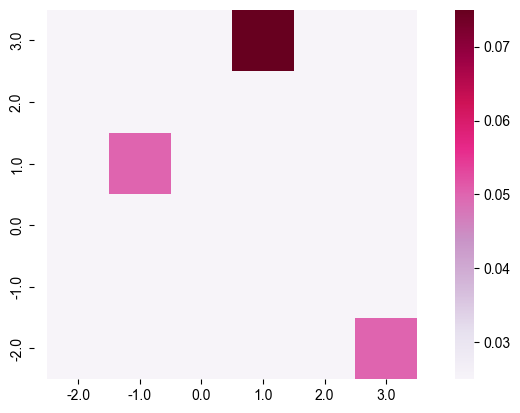

In [24]:
# Dummy data to check plotting works as expected
hist, values = motif_histogram(np.array([[1, 3], [1, 3], [-1, 1], [3, -2]]), smooth=1)
hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)
show_melodic_motif_histogram(hist, vmin=0, vmax=None, cbar=True) 

In [133]:
corpus = 'essen-china-han'
_, pitches = load_data(corpus, repeats=True)
motifs = interval_motifs(pitches, 2)
hist, values = motif_histogram(motifs, min_value=-1*12, max_value=12, smooth=1)
hist = pd.DataFrame(hist, index=values, columns=values).sort_index(ascending=False)

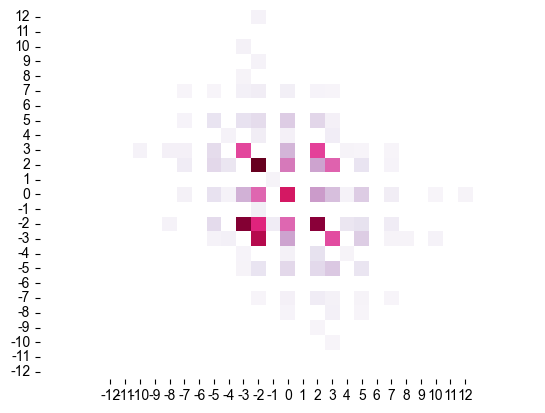

In [139]:
show_melodic_motif_histogram(hist[hist>1e-3])

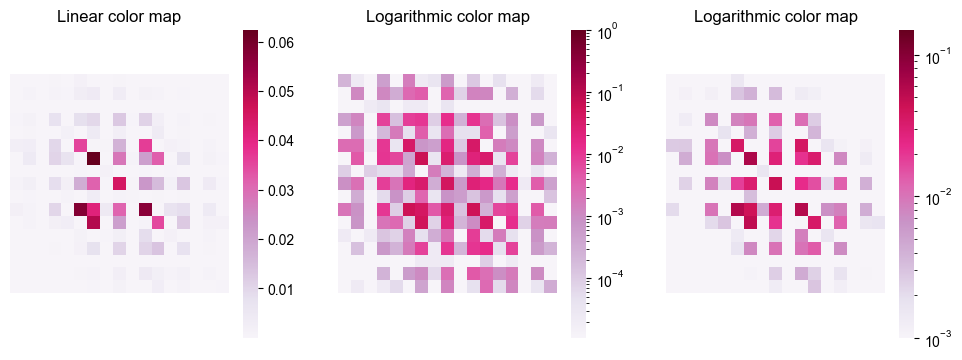

In [136]:
# Linear vs logarithmic color map
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_melodic_motif_histogram('essen-china-han', decorate=False, range=8, 
    # vmin=-0.015, vmax=0.14, 
    ax=axs[0], cbar=True)
axs[0].axis('off')
axs[0].set_title('Linear color map')

plot_melodic_motif_histogram('essen-china-han', decorate=False, range=8, 
    norm=LogNorm(vmin=hist.min().min(), vmax=1), ax=axs[1], cbar=True)
axs[1].set_title('Logarithmic color map')
axs[1].axis('off')

plot_melodic_motif_histogram('essen-china-han', decorate=False, range=8, 
    norm=LogNorm(vmin=1e-3, vmax=0.15), ax=axs[2], cbar=True)
axs[2].set_title('Logarithmic color map')
axs[2].axis('off')

if SAVE: plt.savefig('../figures/colorbar.pdf')

In [26]:
# Small plots
if SAVE:
    for corpus in CORPORA:
        plt.subplots(figsize=(3, 3), tight_layout=True)
        plot_melodic_motif_histogram(corpus, 
            repeats=True, 
            range=8, 
            norm=LogNorm(vmin=1e-3, vmax=0.15), 
            decorate=False, 
        )
        plt.savefig(f'../figures/melody-squares/small/melody-square-small-{corpus}.pdf')
        plt.close()

# For linear color map use vmin=-0.015, vmax=0.14

In [27]:
# Large plots
if SAVE:
    for corpus in CORPORA:
        plt.subplots(figsize=(6, 6), tight_layout=True)
        plot_melodic_motif_histogram(corpus, 
            repeats=True, 
            range=25, 
            # Note that the minimum value in this data is 1e-5 (see below)
            norm=LogNorm(vmin=1e-4, vmax=0.15), 
        )
        plt.savefig(f'../figures/melody-squares/large/melody-square-large-{corpus}.pdf')
        plt.close()

## Plot residuals: deviations from global average

In [61]:
def residual_histograms(corpora=CORPORA, **kwargs):
    histograms = collect_histograms(corpora=CORPORA, **kwargs)
    hists = np.array([h.values for h in histograms])
    mean = pd.DataFrame(
        hists.mean(axis=0), 
        index=histograms[0].index, 
        columns=histograms[0].columns)
    residuals = [hist - mean for hist in histograms]
    return mean, residuals

Text(0.5, 1.0, 'Average motif frequencies')

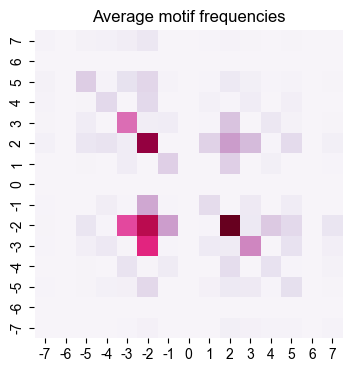

In [62]:
mean, _ = residual_histograms(CORPORA)
plt.figure(figsize=(4, 4))
show_melodic_motif_histogram(mean)
plt.title('Average motif frequencies')

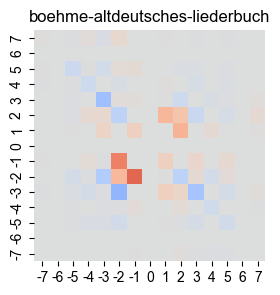

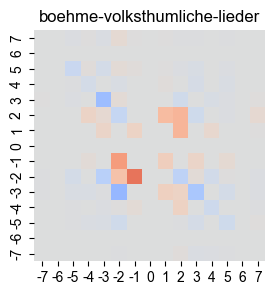

In [63]:
_, residuals = residual_histograms(CORPORA)
for corpus, hist in zip(CORPORA[:2], residuals):
    plt.figure(figsize=(3, 3))
    show_melodic_motif_histogram(hist, cmap='coolwarm', vmin=-.075, vmax=.075)
    plt.title(corpus)
    plt.show()
    

## Clustering

In [28]:
def matrix_pdist(matrices, ord=None):
    dists = np.zeros((len(matrices), len(matrices)))
    for i, df0 in enumerate(matrices):
        for j, df1 in enumerate(matrices):
            if i > j: continue
            dists[i, j] = np.linalg.norm(df0 - df1, ord=ord)
            dists[j, i] = np.linalg.norm(df0 - df1, ord=ord)
    return dists

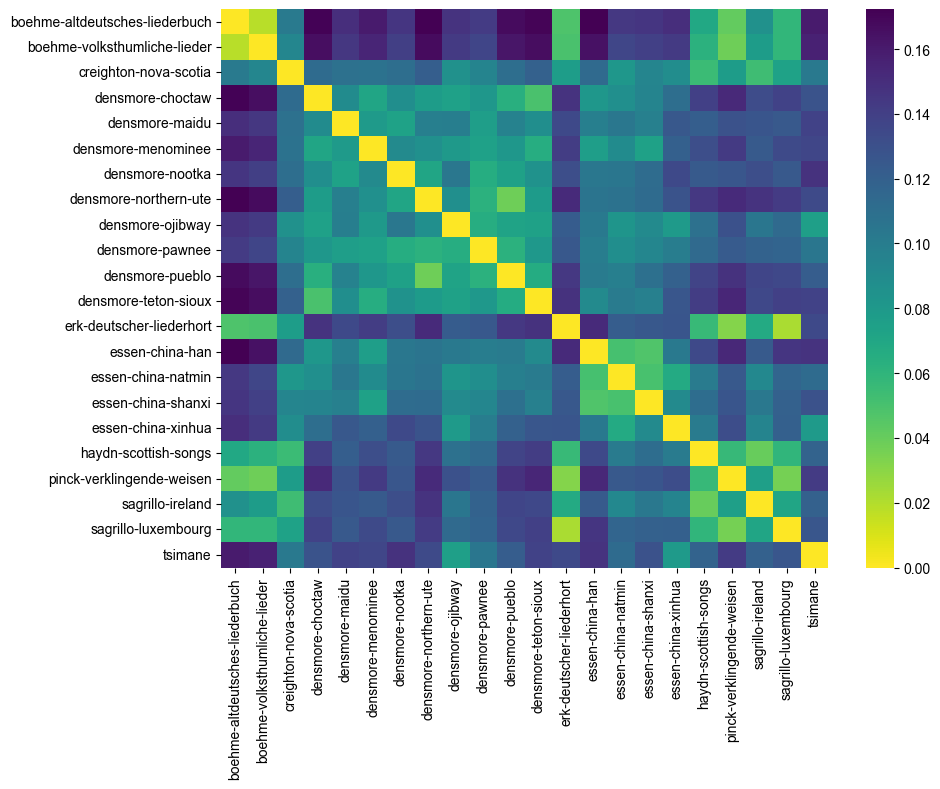

In [29]:
plt.figure(figsize=(10, 8), tight_layout=True)
histograms = collect_histograms(CORPORA, min_value=-12, max_value=12)
dists = matrix_pdist(histograms, ord='fro')
sns.heatmap(dists, xticklabels=CORPORA, yticklabels=CORPORA, cmap='viridis_r')
if SAVE: plt.savefig('../figures/melody-squares/melody-squares-distance-matrix.pdf')

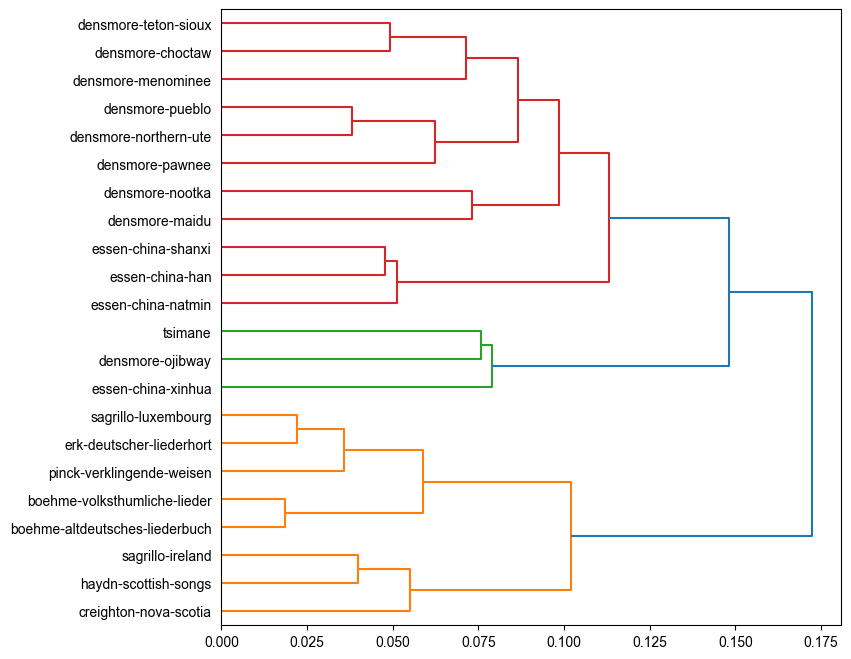

In [30]:
from scipy.spatial.distance import squareform
from scipy import cluster

plt.figure(figsize=(8, 8))
Z = cluster.hierarchy.linkage(squareform(dists), "complete")
cluster.hierarchy.dendrogram(Z, labels=CORPORA, orientation='right');
if SAVE: plt.savefig('../figures/melody-squares/melody-squares-tree.pdf')

## Group averages

In [31]:
groups = dict(
    china = [
        'essen-china-han',
        'essen-china-natmin',
        'essen-china-shanxi',
        'essen-china-xinhua',
        # 'tsimane'
    ],
    europe = [
        'boehme-altdeutsches-liederbuch',
        'boehme-volksthumliche-lieder',
        'creighton-nova-scotia',
        'erk-deutscher-liederhort',
        'haydn-scottish-songs',
        'pinck-verklingende-weisen',
        'sagrillo-ireland',
        'sagrillo-luxembourg',
    ],
    north_america = [
        'densmore-choctaw',
        'densmore-maidu',
        'densmore-menominee',
        'densmore-nootka',
        'densmore-northern-ute',
        'densmore-ojibway',
        'densmore-pawnee',
        'densmore-pueblo',
        'densmore-teton-sioux',
    ],
    all=CORPORA,
)

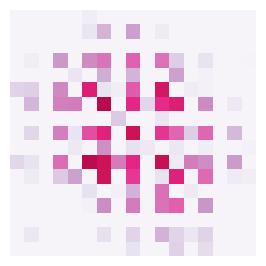

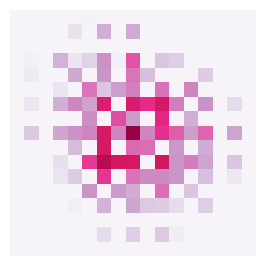

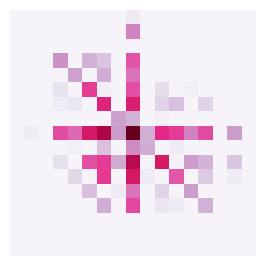

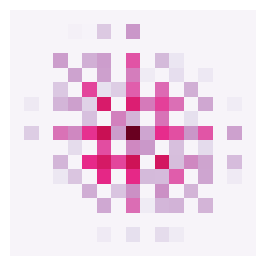

In [32]:
for group, corpora in groups.items():
    histograms = collect_histograms(corpora, min_value=-8, max_value=8, repeats=True)
    average = np.mean([h.values for h in histograms], axis=0)
    plt.figure(figsize=(3, 3))
    show_melodic_motif_histogram(
        average,
        norm=LogNorm(vmin=1e-3, vmax=0.15), 
    )
    plt.tight_layout()
    plt.axis('off'); plt.axis('equal')
    if SAVE:
        plt.savefig(f'../figures/melody-squares/averages/melody-square-average-{group}.pdf')
        plt.close()


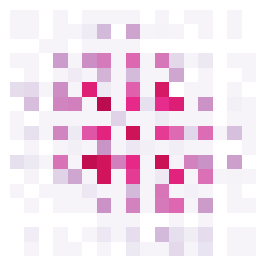

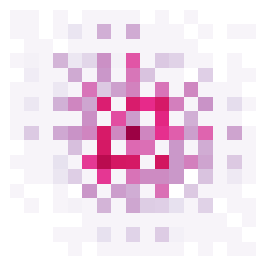

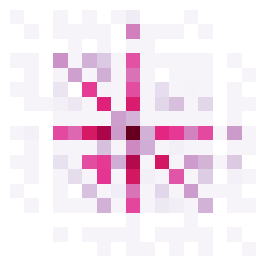

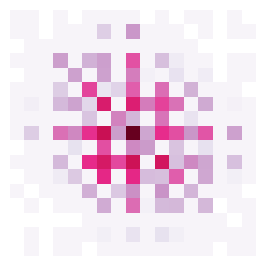

In [23]:
for group, corpora in groups.items():
    histograms = collect_histograms(corpora, min_value=-8, max_value=8, repeats=True)
    average = np.mean([h.values for h in histograms], axis=0)
    plt.figure(figsize=(3, 3))
    show_melodic_motif_histogram(
        average,
        norm=LogNorm(vmin=1e-3, vmax=0.15), 
    )
    plt.tight_layout()
    plt.axis('off'); plt.axis('equal')
    if SAVE:
        plt.savefig(f'../figures/melody-squares/averages/melody-square-average-{group}.pdf')
        plt.close()


['boehme-altdeutsches-liederbuch',
 'boehme-volksthumliche-lieder',
 'creighton-nova-scotia',
 'erk-deutscher-liederhort',
 'haydn-scottish-songs',
 'pinck-verklingende-weisen',
 'sagrillo-ireland',
 'sagrillo-luxembourg']

In [63]:
histograms = collect_histograms(groups['europe'], min_value=-8, max_value=8, repeats=True)
average = np.mean([h.values for h in histograms], axis=0)

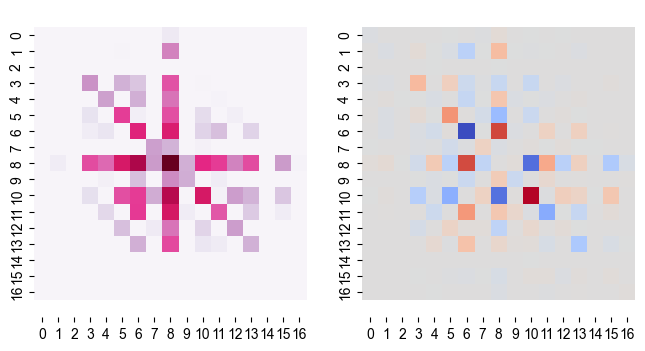

In [98]:
histograms = collect_histograms(groups['north_america'], min_value=-8, max_value=8, repeats=True)
average = np.mean([h.values for h in histograms], axis=0)


plt.figure(figsize=(12, 4))
plt.subplot(131)
show_melodic_motif_histogram(
    average,
    norm=LogNorm(vmin=1e-3, vmax=0.15), 
)

mirrored = np.rot90(average.T, 2)
diffs = average - mirrored
plt.subplot(132)
show_melodic_motif_histogram(
    diffs,
    cmap='coolwarm'
    # norm=LogNorm(vmin=1e-3, vmax=0.15), 
)

# plt.subplot(133)
# show_melodic_motif_histogram(
#     np.abs(average - average.T),
#     norm=LogNorm(vmin=1e-3, vmax=0.15), 
# )

In [111]:
x = 2
y = -3

motif = average[N - y, x + N]
mirror = average[N - x, y + N]
motif, mirror

(0.0006408352023274975, 0.0007953171232699744)

In [121]:
np.abs(average - motif).ravel().mean()

0.0033873361889866266

In [122]:
np.abs(motif -)

0.00015448192094247694

In [131]:
for x in range(-N, N+1):
    for y in range(x + 1, N+1):
        motif = average[N - y, x + N]
        mirror = average[N - x, y + N]
        diff = np.abs(mirror-motif)
        avgdiff = np.abs(average - motif).ravel().mean()
        print(diff / avgdiff)

0.0
0.0
0.0
0.012167283342757912
0.0
0.014159923667557273
0.0
0.060310012206791094
0.013150134675842024
0.0
0.03505278076436
0.0
0.028940511452634418
0.0
0.0
0.04804662338081655
0.0
0.006414336212838761
0.0
0.020411577597379677
0.04585211247939167
0.0040312461529964875
0.10662539483015557
0.0
0.07489335423910738
0.06180366011976194
0.04617195190671173
0.057955564655760454
0.0
0.07168635512081949
0.0
0.0
0.0
0.0
0.0
0.0
0.0042639672407100235
0.0
0.003168794982854447
0.0
0.00316563635314511
0.0
0.0
0.0
0.0
0.16879720478249502
0.02729094890685252
0.535379546696056
0.006974228159687529
0.04837221376235752
0.04394013044825656
0.06795273630795734
0.10881578804187018
0.01965318696359745
0.34756987244486304
0.0
0.10080481382189471
0.005314689725892133
0.2439498408521879
0.06202841084477584
0.05548116853118721
0.14507301087816213
0.025655158938154506
0.1699406300853187
0.00823003803592742
0.04967523276085328
0.01206185740914403
0.004820839730490755
0.004352802477404783
0.0
0.28230647420202637
0